In [1]:
import numpy as np
from pysrc.optimization import gams, gurobi
from pysrc.sampling import baseline
from pysrc.services.data_service import load_site_data
from pysrc.analysis import value_decomposition

/Users/ph2696/Projects/project-amazon/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model scenario

In [2]:
opt = "gurobi"
pee = 7.1
pa = 41.11
b = 25
sitenum = 78
T = 200
timehzn = T + 200

## Solve model

In [3]:
# Load site data
(
    zbar_2017,
    z_2017,
    forest_area_2017,
    _,
    _,
    _,
    _,
) = load_site_data(sitenum)

# Set productivity parameters using baseline mean
baseline_fit = baseline.sample(
    model_name="full_model",
    num_sites=sitenum,
    iter_sampling=10**4,
    chains=5,
    seed=1,
)

theta = baseline_fit.stan_variable("theta").mean(axis=0)
gamma = baseline_fit.stan_variable("gamma").mean(axis=0)

# Computing carbon absorbed in start period
x0_vals = gamma * forest_area_2017

# Choose optimizer
if opt == "gurobi":
    solve_planner_problem = gurobi.solve_planner_problem

elif opt == "gams":
    solve_planner_problem = gams.solve_planner_problem

else:
    raise ValueError("Optimizer must be one of ['gurobi', 'gams']")

results = solve_planner_problem(
    T=timehzn,
    theta=theta,
    gamma=gamma,
    x0=x0_vals,
    zbar=zbar_2017,
    z0=z_2017,
    pe=pee + b,
    pa=pa,
)

Data successfully loaded from /Users/ph2696/Projects/project-amazon/data/hmc


19:58:35 - cmdstanpy - INFO - compiling stan file /Users/ph2696/Projects/project-amazon/stan_models/full_model/baseline.stan to exe file /Users/ph2696/Projects/project-amazon/stan_models/full_model/baseline


Data successfully loaded from /Users/ph2696/Projects/project-amazon/data/hmc


19:58:40 - cmdstanpy - INFO - compiled model executable: /Users/ph2696/Projects/project-amazon/stan_models/full_model/baseline
19:58:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status








chain 1 |▉         | 00:00 Iteration:  800 / 10000 [  8%]  (Sampling)








chain 1 |██▏       | 00:00 Iteration: 2200 / 10000 [ 22%]  (Sampling)





chain 1 |███▏      | 00:00 Iteration: 3400 / 10000 [ 34%]  (Sampling)





chain 1 |████▎     | 00:00 Iteration: 4600 / 10000 [ 46%]  (Sampling)




chain 1 |█████▎    | 00:00 Iteration: 5800 / 10000 [ 58%]  (Sampling)





chain 1 |██████▍   | 00:00 Iteration: 7000 / 10000 [ 70%]  (Sampling)





chain 1 |███████▋  | 00:00 Iteration: 8400 / 10000 [ 84%]  (Sampling)



chain 1 |████████▊ | 00:00 Iteration: 9700 / 10000 [ 97%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                        
chain 2 |██████████| 00:00 Sampling completed                        

chain 3 |██████████| 00:00 Sampling com


19:58:41 - cmdstanpy - INFO - CmdStan done processing.



Solving the optimization problem...
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file /var/folders/d1/k6sr3htd7fdgk614mmq8pwq00000gr/T/tmp0e9ybtpj.pyomo.lp
Reading time = 0.17 seconds
x1: 62800 rows, 125201 columns, 312166 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 62800 rows, 125201 columns and 312166 nonzeros
Model fingerprint: 0xbed24d14
Model has 400 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-04, 6e+03]
  QObjective range [6e+01, 2e+05]
  Bounds range     [3e-04, 1e+00]
  RHS range        [6e-07, 7e+00]
Presolve removed 31202 rows and 31204 columns
Presolve time: 0.05s
Presolved: 31598 rows, 93997 columns, 187515 nonzeros
Presolved model has 400 quadratic objective terms
Ordering time: 0.01s

Barrier s

In [4]:
value_decomposition(
    Z=results["Z"],
    X=results["X"],
    U=results["U"],
    V=results["V"],
    T=timehzn,
    pee=pee,
    pa=pa,
    b=b,
    theta=theta,
)

{'pa': 41.11,
 'pee': 7.1,
 'b': 25,
 'total_AO': 17.401965000559894,
 'total_NT': 352.80108819765985,
 'total_FS': 100.19550904813539,
 'total_AC': 26.965751255072796,
 'total_PV': 443.43281099128234}

In [5]:
V = [
    value_decomposition(
        Z=results["Z"][t:],
        X=results["X"][t:],
        U=results["U"][t:],
        V=results["V"][t:],
        T=T,
        pee=pee,
        pa=pa,
        b=b,
        theta=theta,
    )["total_PV"]
    for t in range(timehzn - T)
]

<function matplotlib.pyplot.show(close=None, block=None)>

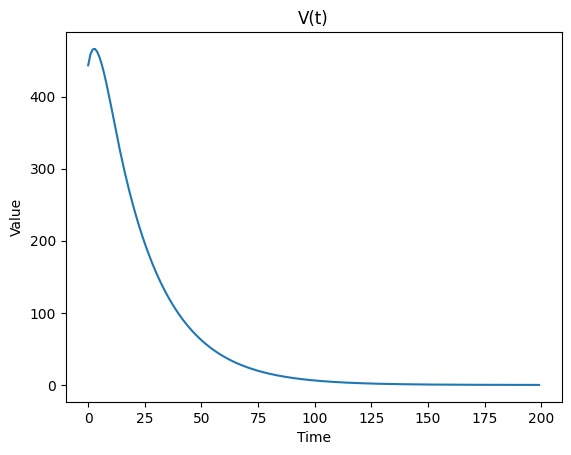

In [6]:
import matplotlib.pyplot as plt

# Plotting the line plot
plt.plot(V)

# Adding labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("V(t)")

# Displaying the plot
plt.show

In [7]:
W = []
for t in range(timehzn - T):
    defection = solve_planner_problem(
        T=200,
        theta=theta,
        gamma=gamma,
        x0=results["X"][t],
        zbar=zbar_2017,
        z0=results["Z"][t],
        pe=pee,
        pa=pa,
    )

    W.append(
        value_decomposition(
            Z=defection["Z"],
            X=defection["X"],
            U=defection["U"],
            V=defection["V"],
            T=200,
            pee=pee,
            pa=pa,
            b=0,
            theta=theta,
        )["total_PV"]
    )

Solving the optimization problem...
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file /var/folders/d1/k6sr3htd7fdgk614mmq8pwq00000gr/T/tmp0jq9xwrz.pyomo.lp
Reading time = 0.08 seconds
x1: 31400 rows, 62601 columns, 155966 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 31400 rows, 62601 columns and 155966 nonzeros
Model fingerprint: 0x54b2818a
Model has 200 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e-03, 1e+03]
  QObjective range [3e+03, 2e+05]
  Bounds range     [3e-04, 1e+00]
  RHS range        [6e-07, 7e+00]
Presolve removed 15602 rows and 15604 columns
Presolve time: 0.02s
Presolved: 15798 rows, 46997 columns, 93715 nonzeros
Presolved model has 200 quadratic objective terms
Ordering time: 0.01s

Barrier stati

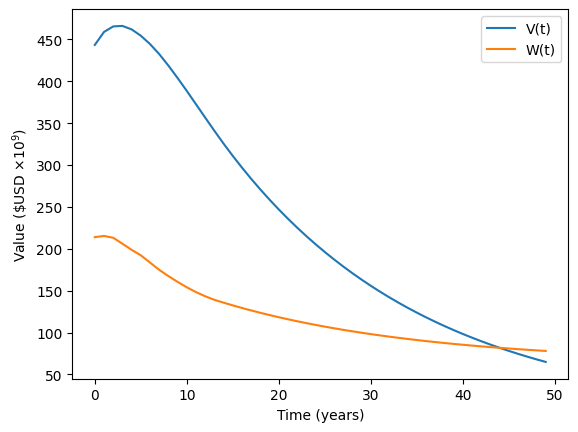

In [52]:
# Plotting the line plots for V and W
plt.plot(V[:50], label="V(t)")
plt.plot(W[:50], label="W(t)")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel(r"Value (\$USD $\times 10^9$)")

# Displaying the plot
plt.show()

## Time and value of defecting

In [12]:
def defect_time(V, W):
    indices = [i for i, (v, w) in enumerate(zip(V, W)) if v < w]
    return indices[0] if indices else -1

In [13]:
defect_time(V, W)

44

## Maximum gap between $V(t)$ and $W(t)$

In [9]:
abs(min([V[i] - W[i] for i in range(timehzn - T)]))

63.64009481764865

In [17]:
abs(min([V[i] - W[i] for i in range(timehzn - T)])) / (1.02 ** (timehzn - T))

1.212541092696603

## Analysing gap

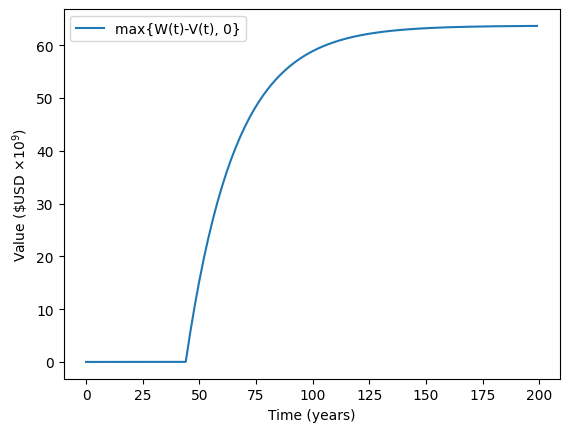

In [42]:
gap = [max(W[t] - V[t], 0) for t in range(timehzn - T)]

# Plotting the line plots for V and W
plt.plot(gap, label="max{W(t)-V(t), 0}")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel(r"Value (\$USD $\times 10^9$)")

# Displaying the plot
plt.show()

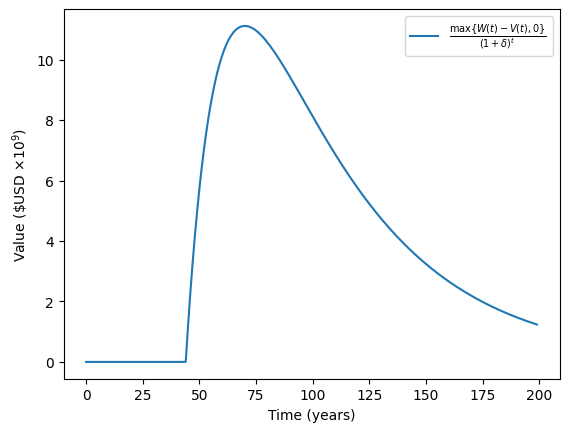

In [43]:
PV_gap = [max(W[t] - V[t], 0) / (1.02 ** (t))  for t in range(timehzn - T)]

# Plotting the line plots for V and W
plt.plot(PV_gap, label=r"$\frac{\max\{W(t)-V(t), 0\}}{(1+\delta)^t}$")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel(r"Value (\$USD $\times 10^9$)")

# Displaying the plot
plt.show()

In [51]:
PV_gap[49]

4.967458306096104